
# Latent Dirichlet Allocation(LDA) for 'Customer interest' modelling


#### Import libraries

In [1]:
# !pip install pyLDAvis

In [2]:
# libraries 
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
from gensim import corpora

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


####   Dataset Analysis

In [4]:
# Read data from csv
customer_review_data= pd.read_csv("E:\\code\\SENETIMENT_ANALYSIS_AMAZON\\LDATopicModelling\\amazon_alexa - amazon_alexa.csv")
print(customer_review_data.head(2))
print(len(customer_review_data))
print('Number of Unique variation')
print(len(customer_review_data.groupby('variation')))

   rating       date        variation verified_reviews  feedback
0       5  31-Jul-18  Charcoal Fabric    Love my Echo!         1
1       5  31-Jul-18  Charcoal Fabric        Loved it!         1
3150
Number of Unique variation
16


In [5]:
# Clean text
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

In [6]:
# In natural language processing, useless words (data), are referred to as stop words. 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Removes the rows that contains NULL values.
customer_review_data.dropna(axis = 0, how ='any',inplace=True) 
customer_review_data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


####   Filter short reviews according to rating

In [28]:
customer_review_data['verified_reviews'] = customer_review_data['verified_reviews'].apply(clean_text)
customer_review_data['Num_words_text'] = customer_review_data['verified_reviews'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(customer_review_data['rating'].value_counts())
print(len(customer_review_data))
print('-------------------------')
max_review_data_sentence_length  = customer_review_data['Num_words_text'].max()

mask = (customer_review_data['Num_words_text'] < 100) & (customer_review_data['Num_words_text'] >=10)
df_short_reviews = customer_review_data[mask]
df_new = df_short_reviews.groupby('rating').apply(lambda x: x.sample(n=40)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    2246
4     447
1     146
3     140
2      92
Name: rating, dtype: int64
3071
-------------------------
No of Short reviews
1338


In [9]:
df_new

,rating,date,variation,verified_reviews,feedback,Num_words_text
0,1,26-Jul-18,Black Plus,disappointed this product tried install differ...,0,45
1,1,30-Jul-18,Black Dot,this worked well about months then stopped con...,0,32
2,1,30-Jul-18,Configuration: Fire TV Stick,will never anything amazon makes againthis fir...,0,33
3,1,30-Jul-18,White Dot,product sounded same emoji speaker from five b...,0,22
4,1,24-Jul-18,Black Plus,returning been nothing annoying cant turned ne...,0,67
...,...,...,...,...,...,...
195,5,30-Jul-18,Configuration: Fire TV Stick,amazed many movies shows more available planni...,1,24
196,5,29-Jul-18,Charcoal Fabric,glad that echo over bluetooth speaker alexa do...,1,42
197,5,30-Jul-18,Black Show,previous experience with echo this just blows ...,1,21
198,5,30-Jul-18,Sandstone Fabric,love echo works just like they said would dont...,1,21


####   Dataset Pre-processing

In [32]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_new['verified_reviews']=df_new['verified_reviews'].apply(remove_stopwords)

In [30]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# create a lemmatization for filtering
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

#### Finding Nouns and Adjectives

In [12]:
text_list=df_new['verified_reviews'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

worked well months stopped connecting internet wifi none trouble shooting efforts worked amazon customer service couldnt help told warranty months disappointing werent willing replace
['month', 'internet', 'none', 'trouble', 'effort', 'customer', 'service', 'warranty', 'month', 'disappointing', 'willing', 'replace']


#### Dictionary and Document term matrix

In [13]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

####  LDA model

In [27]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [47]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=34, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [48]:
lda_model.print_topics()

[(30,
  '0.052*"device" + 0.052*"nice" + 0.052*"product" + 0.026*"reason" + 0.026*"awful" + 0.026*"work" + 0.026*"speaker" + 0.026*"sure" + 0.026*"star" + 0.026*"money"'),
 (16,
  '0.051*"device" + 0.037*"question" + 0.033*"setup" + 0.028*"alexa" + 0.019*"time" + 0.019*"smart" + 0.019*"34im" + 0.019*"sure34" + 0.014*"many" + 0.014*"alarm"'),
 (5,
  '0.028*"money" + 0.028*"extra" + 0.028*"don34" + 0.028*"t" + 0.028*"troubling" + 0.028*"song" + 0.028*"opera" + 0.028*"access" + 0.028*"sound" + 0.001*"purchasing"'),
 (20,
  '0.040*"many" + 0.040*"time" + 0.030*"work" + 0.020*"device" + 0.020*"thing" + 0.020*"second" + 0.020*"confused" + 0.020*"half" + 0.020*"beta" + 0.020*"item"'),
 (17,
  '0.029*"home" + 0.029*"great" + 0.029*"screen" + 0.022*"amazon" + 0.022*"device" + 0.022*"time" + 0.015*"photo" + 0.015*"digital" + 0.015*"prime" + 0.015*"spam"'),
 (12,
  '0.045*"home" + 0.040*"smart" + 0.031*"echo" + 0.026*"great" + 0.026*"device" + 0.022*"sale" + 0.022*"good" + 0.018*"nice" + 0.018*"s

#### Measureing the model

In [53]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=100))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.779348197485575

Coherence Score:  0.38078855854680294


#### Visualize the topics

In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.121216  0.035801       1        1  20.095411
6     -0.033623  0.075870       2        1  13.405277
4      0.060618 -0.110050       3        1  12.173844
8      0.022332  0.003267       4        1  10.652065
3      0.006444  0.084114       5        1   9.278343
5      0.077630  0.042231       6        1   9.040045
7     -0.006247 -0.126231       7        1   8.174633
9     -0.140010  0.012497       8        1   7.753139
1     -0.043508  0.038193       9        1   6.435687
2     -0.064852 -0.055693      10        1   2.991556, topic_info=       Term      Freq      Total Category  logprob  loglift
164  screen  25.00000  25.000000  Default   30.000  30.0000
123   sound  37.00000  37.000000  Default   29.000  29.0000
171    free   8.00000   8.000000  Default   28.000  28.0000
241   video  20.00000  20.000000  Default   27.000  27.0000
154   music  60.00000  60.000000  Default   26.000  26.0000
..      ...       ...        ...      ...      ...      ...
37     good   0.60503  26.132221  Topic10   -5.096  -0.2563
61   access   0.60503   8.216203  Topic10   -5.096   0.9008
254    huge   0.60503   4.406233  Topic10   -5.096   1.5239
340    open   0.60503   2.919495  Topic10   -5.096   1.9355
131    step   0.60503   2.854518  Topic10   -5.096   1.9580

[681 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
539       2  0.837656    342nd
149       3  0.755389     34im
133       1  0.812833    34the
371       1  0.177337  ability
371       2  0.532012  ability
...     ...       ...      ...
598       6  0.659992  yearold
110       1  0.247695  youtube
110       2  0.123848  youtube
110       3  0.371543  youtube
110       8  0.123848  youtube

[1118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 9, 4, 6, 8, 10, 2, 3])

#### Finding the best model 

In [41]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

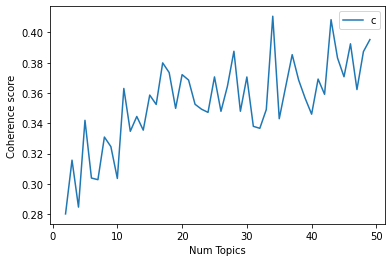

In [43]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2801
Num Topics = 3  has Coherence Value of 0.3156
Num Topics = 4  has Coherence Value of 0.2846
Num Topics = 5  has Coherence Value of 0.342
Num Topics = 6  has Coherence Value of 0.3038
Num Topics = 7  has Coherence Value of 0.3028
Num Topics = 8  has Coherence Value of 0.3309
Num Topics = 9  has Coherence Value of 0.3246
Num Topics = 10  has Coherence Value of 0.3036
Num Topics = 11  has Coherence Value of 0.363
Num Topics = 12  has Coherence Value of 0.3347
Num Topics = 13  has Coherence Value of 0.3445
Num Topics = 14  has Coherence Value of 0.3355
Num Topics = 15  has Coherence Value of 0.3586
Num Topics = 16  has Coherence Value of 0.3525
Num Topics = 17  has Coherence Value of 0.3799
Num Topics = 18  has Coherence Value of 0.3735
Num Topics = 19  has Coherence Value of 0.3499
Num Topics = 20  has Coherence Value of 0.3722
Num Topics = 21  has Coherence Value of 0.3686
Num Topics = 22  has Coherence Value of 0.3526
Num Topics = 23  has Co

In [45]:
# Select the model and print the topics
optimal_model = model_list[32]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(16,
  '0.031*"camera" + 0.021*"echo" + 0.021*"video" + 0.019*"great" + 0.019*"sound" + 0.016*"love" + 0.013*"quality" + 0.012*"good" + 0.012*"little" + 0.012*"issue"'),
 (29,
  '0.078*"music" + 0.038*"sound" + 0.038*"prime" + 0.025*"family" + 0.025*"device" + 0.020*"product" + 0.019*"repair" + 0.018*"clock" + 0.018*"need" + 0.017*"screen"'),
 (15,
  '0.027*"full" + 0.023*"bulb" + 0.022*"alexa" + 0.022*"price" + 0.022*"work" + 0.022*"question" + 0.022*"sound" + 0.017*"echo" + 0.012*"light" + 0.011*"speaker"'),
 (25,
  '0.040*"free" + 0.030*"bulb" + 0.022*"device" + 0.020*"search" + 0.020*"first" + 0.020*"purchase" + 0.020*"amazon" + 0.020*"information" + 0.020*"ability" + 0.012*"voice"'),
 (0,
  '0.046*"screen" + 0.031*"product" + 0.024*"sure" + 0.016*"present" + 0.015*"money" + 0.015*"turn" + 0.012*"cylinder" + 0.012*"camera" + 0.012*"talk" + 0.012*"way"'),
 (33,
  '0.024*"sound" + 0.023*"great" + 0.023*"program" + 0.023*"music" + 0.020*"speaker" + 0.020*"thing" + 0.016*"quality" + 0

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.081977  0.007192       1        1  9.216536
1      0.144432 -0.072438       2        1  6.260553
13     0.083335  0.190325       3        1  5.875731
8      0.035570 -0.116087       4        1  5.673632
20     0.030817 -0.057403       5        1  4.882583
31     0.083409  0.005927       6        1  4.422362
16     0.080125 -0.002007       7        1  4.335060
33     0.064853 -0.022699       8        1  4.246960
4      0.081805 -0.072036       9        1  4.201834
29     0.087038  0.020052      10        1  4.122590
6      0.045758  0.044057      11        1  3.576886
23     0.132242 -0.043754      12        1  3.545288
11     0.083020  0.021887      13        1  3.504106
28     0.106227  0.017616      14        1  3.396507
26    -0.072731  0.014773      15        1  2.685548
30    -0.052103  0.065927      16        1  2.633173
10    -0.008179  0.048541      17        1  2.594989
5     -0.001619 -0.058754      18        1  2.564630
32     0.027754  0.076856      19        1  2.354420
15    -0.025010  0.096005      20        1  2.295160
3      0.034119  0.019760      21        1  2.230380
25    -0.093631  0.095841      22        1  2.022838
7     -0.030869  0.057865      23        1  1.966780
12     0.040065 -0.109330      24        1  1.592601
0     -0.037402 -0.056572      25        1  1.408662
21    -0.088636 -0.036282      26        1  1.200013
9     -0.103411 -0.054142      27        1  1.076491
24    -0.042909  0.028578      28        1  1.051282
17    -0.096076  0.035846      29        1  1.050683
27    -0.102479  0.025928      30        1  1.021974
14    -0.135550 -0.066263      31        1  0.955919
19    -0.126973 -0.053137      32        1  0.832061
22    -0.125187 -0.011639      33        1  0.775347
18    -0.099780 -0.040431      34        1  0.426421, topic_info=             Term       Freq      Total Category  logprob  loglift
154         music  61.000000  61.000000  Default  30.0000  30.0000
30         device  73.000000  73.000000  Default  29.0000  29.0000
164        screen  25.000000  25.000000  Default  28.0000  28.0000
29         amazon  18.000000  18.000000  Default  27.0000  27.0000
84          smart  21.000000  21.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
132         voice   0.120797  14.162551  Topic34  -4.7590   0.6933
308  amazonzigbee   0.010455   1.279601  Topic34  -7.2060   0.6503
232          show   0.104440  20.487242  Topic34  -4.9045   0.1786
30         device   0.262561  73.911766  Topic34  -3.9827  -0.1826
16           time   0.119067  40.361182  Topic34  -4.7735  -0.3684

[1633 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
236      14  0.640756   1030pm
744      15  0.630986    24ghz
539       4  0.445243    342nd
149      18  0.318625     34im
149      27  0.318625     34im
...     ...       ...      ...
110      30  0.125536  youtube
320      25  0.781242   zigbee
476       7  0.651423    zwave
276      20  0.650656     zzzz
178      14  0.638720      ’ve

[2127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 14, 9, 21, 32, 17, 34, 5, 30, 7, 24, 12, 29, 27, 31, 11, 6, 33, 16, 4, 26, 8, 13, 1, 22, 10, 25, 18, 28, 15, 20, 23, 19])